In a previous post, we saw how to enforce Dirichlet boundary conditions for the Poisson equation using Nitsche's method instead of the usual elimination-based approach.
For other problems, elimination doesn't work because the Dirichlet boundary conditions involve, say, a linear combination 
of the solution degrees of freedom.
In this post we'll look at enforcing *friction* boundary conditions for Stokes flow.
Friction boundary conditions are a little exotic, and the elimination approach is no longer feasible.
Consequently we have no choice but to use the penalty method or Nitsche's method.

The [Stokes equations](https://en.wikipedia.org/wiki/Stokes_flow) are what you get when you assume a fluid flows so slowly that acceleration is negligible.
The fields we are solving for are the velocity $u$ and presure $p$.
In a previous post, I showed that the Stokes equations can be derived from a variational principle.
The objective for the Stokes equations is the rate of decrease of the *Gibbs free energy*:

$$\dot{\mathscr{G}}(u, p) = \int_\Omega\left(\frac{1}{2}\tau : \dot\varepsilon - p\nabla\cdot u - f\cdot u\right)dx,$$

where

$$\dot\varepsilon(u) = \frac{1}{2}(\nabla u + \nabla u^*)$$

is the strain rate tensor and, for a Newtonian fluid,

$$\tau = 2\mu\dot\varepsilon$$

is the stress tensor.
The fact that the Stokes equations have a variational principle at all can be viewed as a consequence of the [Onsager reciprocity relation](https://en.wikipedia.org/wiki/Onsager_reciprocal_relations), a fairly deep result in non-equilibrium statistical mechanics.

The Stokes equations are a constrained optimization problem and this makes them much harder to solve than unconstrained ones, like the Poisson equation.
In the previous post, we showed some approaches for how to solve the linear sytems we get from discretizing the Stokes equations.
Here we'll use all of this knowledge to see how we can solve the Stokes equations with an unusual set of boundary conditions.

### Friction boundary conditions

For most fluid flow problems we assume that the velocity is fixed to some value $u_\Gamma$ around the boundary of the domain.
I make a living modeling the flow of glaciers and this subject throws an interesting curveball in the form of ice sliding.
The speed of glacier sliding over bedrock isn't fixed to some predetermined value; instead, the sliding speed is determined by frictional resistance, which is itself a function of the sliding speed.
Deformable water-laden sediments offer very little resistance at all, while a hard crystalline bedrock has a lot of surface roughness and thus a high friction coefficient.
How should we enforce this boundary condition in practical computations?

The friction boundary condition for Stokes flow is

$$(I - n\otimes n)\tau\cdot n = -\kappa(I - n\otimes n)(u - u_\Gamma),$$

where $n$ is the unit outward normal vector, $I$ is the identity matrix, and $\kappa$ is the drag coefficient.
The extra factors of $I - n\otimes n$ restrict everything to the plane tangential to the boundary.
We're going to have to write it so often that it's worth introducing the shorthand

$$\Pi v = (I - n\otimes n)v$$

to denote the projection $\Pi$ of a direction vector onto the tangent plane to the surface $\Gamma$.

In the perpendicular direction, the fluid velocity is 0:

$$u\cdot n = 0$$

which represents the fact that material can't leave the domain.
Collectively, these are a Robin boundary condition in the tangential direction and a Dirichlet condition in the normal direction.
The action functional with friction boundary conditions is

$$\dot{\mathscr{G}} = \int_\Omega\left(\frac{1}{2}\tau:\dot\varepsilon - p\nabla\cdot u - f\cdot u\right)dx + \frac{1}{2}\int_{\partial\Omega}\kappa(u - u_\Gamma)\cdot\Pi(u - u_\Gamma)ds.$$

We haven't addressed the Dirichlet BC, which is difficult to enforce directly. 
The normal vector $n$ is defined on mesh faces, while for many common finite elements the velocities $u$ are defined on mesh vertices and other facets.

One interesting thing to look at from a physics perspective is that the introduction of the friction coefficient now gives us more dimensionless numbers besides the Reynolds number $\text{Re} = \rho UL / \mu$.
The viscosity coefficient has units of stress $\times$ time, while the friction coefficient has units of stress $\times$ time $\times$ length${}^{-1}$.
From these two coefficients we can form a new length scale

$$\ell = \mu / \kappa$$

which is completely independent of the domain size $L$.
We can then define a new dimensionless number $\ell / L$.
You can think of $\ell$ as a length scale over which the velocity in the interior adjusts to the velocity at the boundary.
As $\kappa \to \infty$, our friction boundary condition looks more and more like a Dirichlet boundary condition.
For the following, we'll choose the friction coefficient so that this ratio is about equal to 1, but it's a fun experiment to see what happens as you make it larger or smaller.

### The Lagrange multiplier

For the Poisson equation, introducing a Lagrange multiplier on the boundary did not give a feasible numerical method and the Stokes equations are no different.
Nonetheless, we were able to explicitly describe the boundary Lagrange multiplier and this was necessary to figure out the correct form of the Nitsche functional.
Let's try the same thing with the Stokes equations.
The Lagrangian functional that incorporates the no-penetration constraint is

$$\mathscr{L}(u, p, \lambda) = \dot{\mathscr{G}} - \int_{\partial\Omega}\lambda u\cdot n\; ds.$$

The differential of the Lagrangian along a velocity $v$ is

$$\begin{align}
\left\langle\frac{\partial\mathscr{L}}{\partial u}, v\right\rangle & = \int_\Omega\left(2\mu\dot\varepsilon(u):\dot\varepsilon(v) - p\nabla\cdot v - f\cdot v\right)dx \\
& \quad + \int_{\partial\Omega}\kappa(u - u_\Gamma)\cdot\Pi v\; ds - \int_{\partial\Omega}\lambda v\cdot n\; ds.
\end{align}$$

We'll pursue the same strategy as before: push the derivatives of $v$ over onto $u$ assuming a strong solution exists, then collect boundary terms.
This time we've got more than one direction to work with and that'll force us to be a bit more creative.

First, using Green's theorem and assuming $u$ and $p$ are nice enough, the last equation is

$$\ldots = \int_\Omega\left(-\nabla\cdot\tau + \nabla p - f\right)\cdot v\; dx + \int_{\partial\Omega}\left\{(\tau - pI)\cdot n + \kappa\Pi(u - u_\Gamma) - \lambda n\right\}\cdot v\; ds$$

where we've used the definition of the deviatoric stress tensor.
To continue, we'll decompose $v$ into a normal and a tangential component:

$$v = (v\cdot n)n + \Pi v$$

and use the fact that the inner product of a vector normal to the boundary with a tangential vector is zero.
The boundary integral then becomes

$$\int_{\partial\Omega}\cdots ds = \int_{\partial\Omega}\left\{n\cdot(\tau - pI)n - \lambda\right\}v\cdot n\; ds + \int_{\partial\Omega}\left(\tau\cdot n + \kappa(u - u_\Gamma)\right)\cdot\Pi v\; ds.$$

In order for $u$, $p$, and $\lambda$ to be a critical point of the Lagrangian, we need all of these terms to be zero.
As expected, we recover the friction boundary condition

$$\Pi\tau\cdot n = -\kappa\Pi(u - u_\Gamma),$$

but we also get an exact expression for the Lagrange multiplier:

$$\lambda = n\cdot(\tau - pI)n.$$

We can also recognize that the full (not deviatoric) stress tensor $\sigma$ is defined as $\sigma = \tau - pI$, in which case the last expression can be rewritten as

$$\lambda = n\cdot\sigma n.$$

In other words, the Lagrange multiplier is just the normal stress!

### Nitsche's method

The Nitsche functional for our problem is defined the same way as for the Poisson problem -- you substitute the expression for $\lambda$ into the augmented Lagrangian:

$$\dot{\mathscr{G}}_\gamma(u, p) = \dot{\mathscr{G}} - \int_{\partial\Omega}(n\cdot\sigma n)(u\cdot n)ds + \int_{\partial\Omega}\frac{\gamma\kappa}{2h}(u\cdot n)^2ds.$$

From here the derivation for how big $\gamma$ needs to be follows the exact same steps as for the Poisson equation.
First, the middle term is broken up into the weighted mean square normal stress and the mean square normal velocity using the Peter-Paul inequality.
Then we control the boundary stress in terms of the interior stress dissipation using the inverse inequality, only for tensors instead of vectors this time.
From the explicit expression for the constant in the inverse inequality we can then determine just how big the penalty needs to be.
The only difference is that, for the Poisson equation, there were $d$ vector components of the gradient, so we had to multiply the inverse inequality constant by $d$; in our case, there are $d^2$ components of the strain rate tensor.
This argument gives

$$\gamma = 2\alpha^{-2}\cdot d\cdot p\cdot (d + p - 1)\cdot\sec\theta\cdot\cot\frac{\theta}{2}.$$

Let's see how well this works on a real example.

### Geometry

We'll use the same domain as the previous example -- a circle of radius 1 with two circles of radius 1/8 removed from it.

In [1]:
import numpy as np
from numpy import pi as π
def add_ellipse(geometry, x, y, a, b, N, lcar):
    θs = np.array([2 * π * n / N for n in range(N)])
    xs, ys = x + a * np.cos(θs), y + b * np.sin(θs)
    points = [geometry.add_point([x, y, 0], lcar=lcar) for x, y in zip(xs, ys)]
    lines = [geometry.add_line(points[n], points[(n + 1) % N])
             for n in range(N)]

    geometry.add_physical(lines)
    line_loop = geometry.add_line_loop(lines)
    return line_loop

In [2]:
import pygmsh
geometry = pygmsh.built_in.Geometry()

outer_line_loop = add_ellipse(geometry, x=0, y=0, a=1, b=1, N=128, lcar=1/4)
inner_loops = [
    add_ellipse(geometry, x=0, y=+1/2, a=1/8, b=1/8, N=64, lcar=1/4),
    add_ellipse(geometry, x=0, y=-1/2, a=1/8, b=1/8, N=64, lcar=1/4)
]

plane_surface = geometry.add_plane_surface(outer_line_loop, inner_loops)
geometry.add_physical(plane_surface)

with open('mixer.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())
    
!gmsh -2 -format msh2 -v 0 -o mixer.msh mixer.geo

In [3]:
import firedrake
mesh = firedrake.Mesh('mixer.msh')

We have to do a bit of extra work to calculate the minimum angle of a mesh cell.

In [4]:
from numpy.linalg import norm

def minimum_angle(mesh):
    coords = mesh.coordinates.dat.data_ro
    cells = mesh.coordinates.cell_node_map().values

    if not ((mesh.cell_dimension() == 2) and
            mesh.is_piecewise_linear_simplex_domain()):
        raise ValueError("Only works on 2D triangular mesh!")

    min_angle = np.inf
    for cell in cells:
        for k in range(3):
            x, y, z = coords[np.roll(cell, k)]
            ζ, ξ = y - x, z - x
            angle = np.arccos(np.inner(ζ, ξ) / (norm(ζ) * norm(ξ)))
            min_angle = min(angle, min_angle)

    return min_angle

θ = minimum_angle(mesh)

Just like in the previous example, we'll set the velocity on the outer boundary to be 0, while the inner two circles are rotating with a fixed speed of 1.

In [5]:
from firedrake import Constant, as_vector
x = firedrake.SpatialCoordinate(mesh)

x2 = Constant((0, +1/2))
r2 = Constant(1/8)
x3 = Constant((0, -1/2))
r3 = Constant(1/8)

q2 = (x - x2) / r2
q3 = (x - x3) / r3

u_Γ = (
    as_vector((0., 0.)),
    as_vector((-q2[1], q2[0])),
    as_vector((-q3[1], q3[0]))
)

### Solution

Now we can define our problem in much the same way as the last demo.
We'll use the same function spaces, viscosity, and solver parameters.

In [6]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=1)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)
Z = V * Q

Knowing the minimum angle of the mesh, the spatial dimension, and the polynomial degree for the velocity space, we can calculate the penalty parameter for Nitsche's method with no manual tuning at all.

In [7]:
k, d = 2, 2
η = 2 * d * k * (k + d - 1) / np.cos(θ) / np.tan(θ / 2)

And here we'll set the physical parameters for the problem.
For the Stokes equations to be reasonable, we need a much larger viscosity than the product of the domain size and the characteristic speed, so we're using $\mu = 10^3$.
We've also chosen a value of the friction coefficient $\kappa$ so that the ratio of the frictional length scale to the domain size is roughly equal to 2.

In [8]:
from firedrake import (
    inner, grad, dx, ds, sym, div, derivative,
    MixedVectorSpaceBasis, VectorSpaceBasis, DirichletBC
)

def ε(u):
    return sym(grad(u))

h = firedrake.CellSize(mesh)
n = firedrake.FacetNormal(mesh)

μ = Constant(1e3)
L = Constant(2.)
κ = Constant(2. * μ / L)

The objective functional has more parts than before, so to make the algebra more tractable we'll make separate variables for each summand.

In [9]:
z = firedrake.Function(Z)
u, p = firedrake.split(z)

u_n = inner(u, n)
Πu = u - u_n * n

I = firedrake.Identity(2)
σ_n = inner(n, (2 * μ * ε(u) - p * I) * n)

Ġ_viscous = μ * inner(ε(u), ε(u)) * dx
Ġ_pressure = p * div(u) * dx

Ġ_friction = 0.5 * κ * sum([inner(Πu - u_γ, Πu - u_γ) * ds(index)
                            for u_γ, index in zip(u_Γ, [1, 2, 3])])
Ġ_lagrange = σ_n * u_n * ds
Ġ_penalty = 0.5 * η * μ / h * u_n**2 * ds
Ġ = Ġ_viscous - Ġ_pressure + Ġ_friction - Ġ_lagrange + Ġ_penalty

The solver parameters specify a direct factorization with MUMPS, which works well for 2D problems but less so for large 3D ones.

In [10]:
parameters = {
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
    'pc_factor_mat_solver_type': 'mumps'
}

basis = VectorSpaceBasis(constant=True)
nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), basis])

firedrake.solve(
    derivative(Ġ, z) == 0, z,
    nullspace=nullspace,
    solver_parameters=parameters
)

u, p = z.split()

Finally we can plot the results.
Compared to the outcome in the last demo where we fixed the velocity around the boundaries, the counter-rotating vortices to either side of the hyperbolic fixed point at the origin have vanished.
If we increase the friction coefficient by a factor of 10 they reappear.
It would be a fun exercise in bifurcation theory to see at what exact value of $\kappa$ the vortices appear.

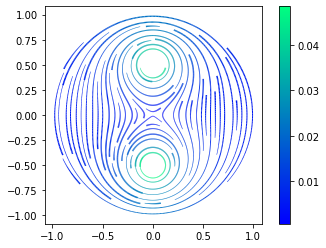

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_aspect('equal')
kwargs = {'resolution': 1/30, 'seed': 0, 'cmap': 'winter'}
streamlines = firedrake.streamplot(u, axes=axes, **kwargs)
fig.colorbar(streamlines);

As another experiment, you can re-run this notebook but reverse the direction of one of the mixer heads, which will remove the fixed point at the origin but will create two more on either side of it.

### Conclusion

When we introduced Nitsche's method, we used it to enforce Dirichlet boundary conditions for the Poisson equation, but this was merely an alternative to the conventional approach.
For the Stokes equations with friction boundary conditions there effectively is no workable conventional approach.
Weird tricks like Nitsche's method are our only hope.
In the next post, I'll try to apply Nitsche's method to nonlinear elliptic PDE, which is even more difficult.